  Copyright(c) 2021 UNIADEX, Ltd. All Rights Reserved.  
  CONFIDENTIAL  
  Author: UNIADEX, Ltd.

# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットから特徴点を抽出するサンプルコードです。抽出した特徴点はElasticsearchに格納されます。

In [18]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

In [19]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [41]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20201201010000-data,9356061,1178983
1,shots-20210327141514-data,13586763,1889104


In [42]:
# 対象データ設定
#target = "20201201010000"
target = "20210327141514"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

# 1ショットで特徴点抽出

## ショット1番を取得して確認

In [5]:
dr = DataReader()

shot_number = 1
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,rawdata_sequential_number,displacement,load01,load02,load03,load04,shot_number,tags
0,1.616790e+09,0,0,8502517,47.92375,-0.006,-0.006,-0.018,-0.005,1,[]
1,1.616790e+09,1,1,8502518,47.92375,-0.007,-0.006,-0.018,-0.009,1,[]
2,1.616790e+09,2,2,8502519,47.92375,-0.006,-0.007,-0.018,-0.008,1,[]
3,1.616790e+09,3,3,8502520,47.92375,-0.006,-0.008,-0.020,-0.008,1,[]
4,1.616790e+09,4,4,8502521,47.91500,-0.005,-0.007,-0.019,-0.007,1,[]


In [43]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,50.847458,109404.0
1,2,NaN,16564.0
2,3,28.571429,9877.0
3,4,32.608696,8640.0
4,5,35.928144,7798.0


In [44]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：3260


In [38]:
pd.set_option('display.max_rows', 3300)
shots_meta_df[shots_meta_df.spm > 80]

,shot_number,spm,num_of_samples_in_cut_out
981,982,400.000000,3878.0
1366,1368,400.000000,3866.0
1377,1380,461.538462,3896.0
2889,2893,428.571429,3840.0


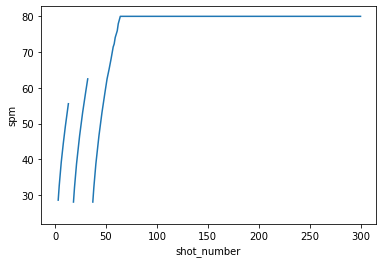

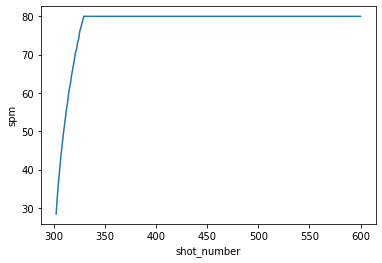

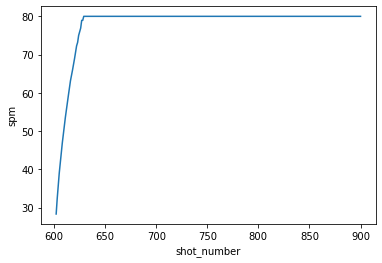

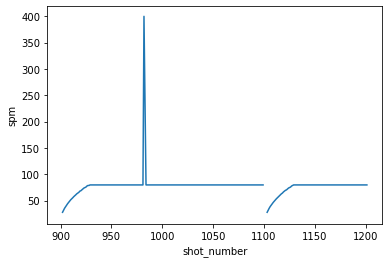

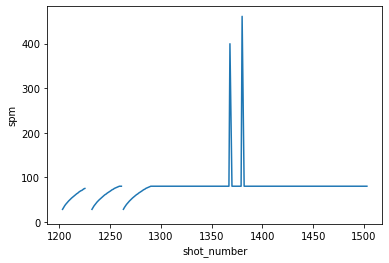

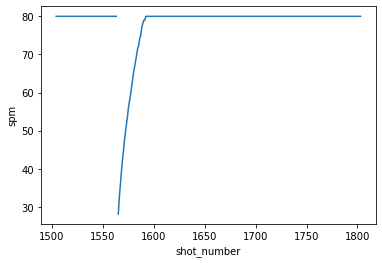

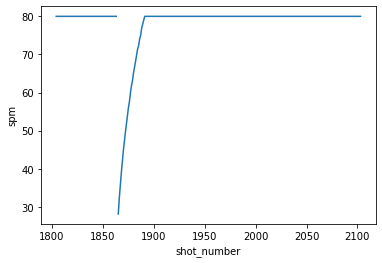

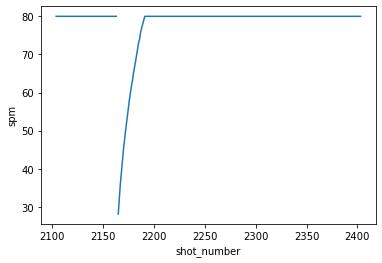

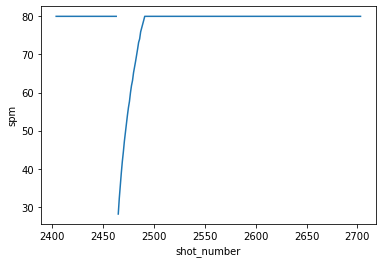

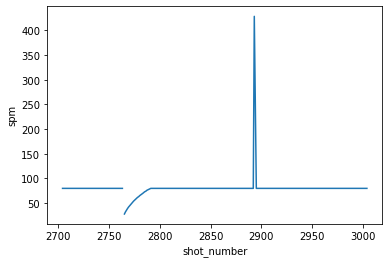

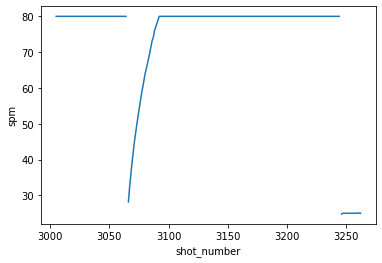

In [46]:
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

step = 300
for i in range(0, 3300, step):
    x = shots_meta_df.shot_number[i:i+step]
    y = shots_meta_df.spm[i:i+step]
    plt.xlabel("shot_number")
    plt.ylabel("spm")
#    fig = plt.figure()
    plt.plot(x, y)
    plt.show()
#    plt.savefig(f"shots-{i}-{i+step}")

In [10]:
# spm
spm = shots_meta_df[shots_meta_df.shot_number == 1].spm
print(f"spm：{spm}")

spm：0    50.847458
Name: spm, dtype: float64


## 特徴点抽出
1ショットから最大荷重点、荷重開始点、破断点を取得します。  

***shot_data***: 対象ショットデータ  
***spm***: spm  
***func***：適用するロジック  
***sub_func***：サブロジック  
***disp_chart***: グラフ表示

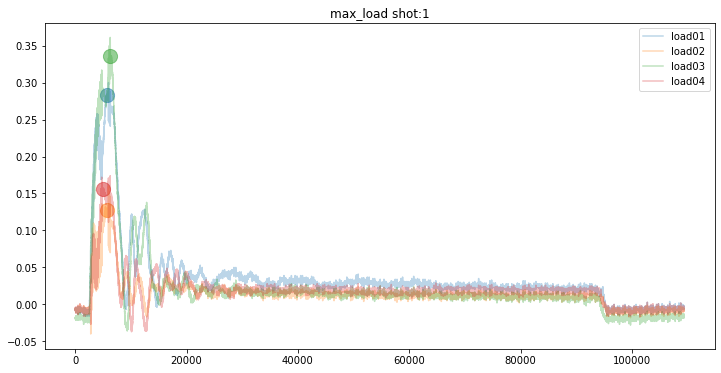

2021-04-01 09:40:06,722 [INFO] NumExpr defaulting to 8 threads.


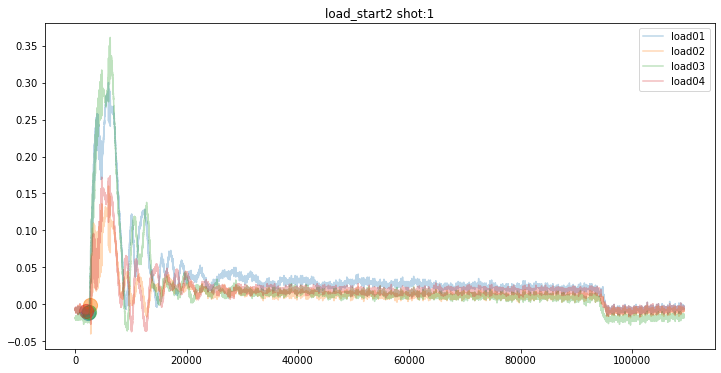

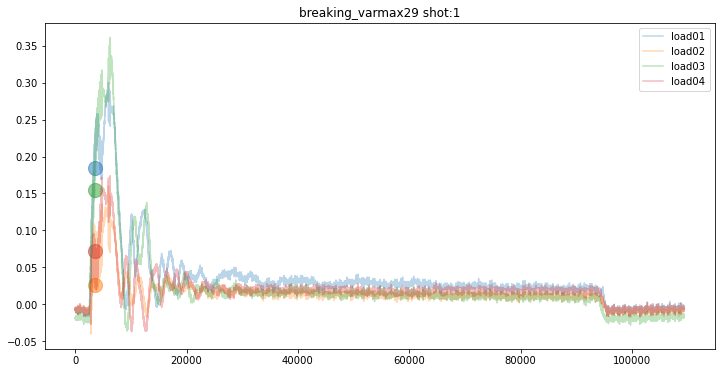

In [11]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_data=shot_df, spm=spm, func=max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values, debug_values = extract_features(shot_df, spm, load_start2, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values, debug_values = extract_features(shot_df, spm, breaking_varmax29, sub_func=narrowing_var_ch,shot=shot_number, disp_chart=True)

In [49]:
# 各特徴点のインデックス番号と値を確認
print(f"【最大荷重点】\n indicies：{max_load_indicies}, values：{max_load_values}")
print(f"【荷重開始点】\n indicies：{load_start_indicies}, values：{load_start_values}")
print(f"【破断点】　　\n indicies：{break_load_indicies}, values：{break_load_values}")

【最大荷重点】
 indicies：[5703, 5643, 6266, 4948], values：[0.28306646136026586, 0.12727712401581162, 0.33582927977411464, 0.15546436842009945]
【荷重開始点】
 indicies：[2264, 2641, 2465, 1963], values：[-0.011353383458646454, -0.0013057644110275272, -0.009952380952380904, -0.009095238095238063]
【破断点】　　
 indicies：[3438, 3437, 3436, 3439], values：[0.18399999999999986, 0.02600000000000007, 0.15500000000000008, 0.07200000000000001]


# 全ショットにロジック適用

## データ読み込み
指定したインデックスの全ショットデータを読み込みます。これには時間がかかります。  
時間目安：10,000,000件読み込みで約3分

In [47]:
# 対象指定
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

In [48]:
%%time
dr = DataReader()
shots_df = dr.multi_process_read_all(shots_data_index)
len(shots_df)

2021-04-02 11:00:12,070 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-04-02 11:00:12,077 [INFO] データ件数: 13586763
2021-04-02 11:00:12,077 [INFO] Data read start. data_count: 13586763.
2021-04-02 11:10:49,006 [WARNING] POST http://localhost:9200/_search/scroll [status:404 request:389.564s]
Process Process-45:
Traceback (most recent call last):
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/elastic_manager/elastic_manager.py", line 335, in range_scan
    data: List[dict] = [x["_source"] for x in data_gen]
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/elastic_manager/elastic_manager.py", line 335, in <listcomp>
    data: List[dict] = [x["_source"] for x in data_gen]
  File "/home/ymiyamoto5/

ConnectionRefusedError: [Errno 111] Connection refused

In [15]:
# ショットメタデータ読み込み
shots_meta_df = dr.read_shots_meta(shots_meta_index)

## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータ  
***shots_meta_df***: ショットメタデータ  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  
***exclude_shots***：除外するショット番号（例：exclude_shots=(1227, 1228, 1229)）

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [ ]:
exclude_shots=(982, 1227, 1228, 1229, 1368, 1380, 2893)

In [16]:
# 最大荷重点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="max",
    func=max_load,
    sub_func=None,
)

2021-04-01 10:11:59,983 [INFO] apply start.
2021-04-01 10:12:23,365 [INFO] apply finished.


In [17]:
max_index = "shots-" + target + "-max-point"
max_df = dr.read_all(max_index)
max_df

2021-04-01 10:13:35,461 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-04-01 10:13:35,467 [INFO] データ件数: 13056
2021-04-01 10:13:35,598 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value
0,1,load04,4948,4948,0.155464
1,1,load02,5643,5643,0.127277
2,1,load01,5703,5703,0.283066
3,1,load03,6266,6266,0.335829
4,2,load01,117992,8588,1.159160
...,...,...,...,...,...
13051,3263,load02,13574962,5284,1.641789
13052,3264,load03,13585109,4953,1.187431
13053,3264,load04,13585161,5005,1.227082
13054,3264,load01,13585758,5602,1.762363


In [18]:
# 荷重開始点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="start",
    func=load_start2,
    sub_func=None,
)

2021-04-01 10:13:43,260 [INFO] apply start.
Process Process-21:
Traceback (most recent call last):
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 104, in apply_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func=sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 666, in extract_features
    i,v,d = func(np.array(shot_data[ch][sub_start:sub_end]),spm,**kwargs)     # ここでnp.arrayになるのでindexがなくなる
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 508, in load_start2
    sd_start = df[100:df.d.idxmax()].sd.idxmin()           # 100

In [19]:
start_index = "shots-" + target + "-start-point"
start_df = dr.read_all(start_index)
start_df

2021-04-01 10:14:16,490 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-04-01 10:14:16,494 [INFO] データ件数: 8160
2021-04-01 10:14:16,593 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value
0,1,load04,1963,1963,-0.009095
1,1,load01,2264,2264,-0.011353
2,1,load03,2465,2465,-0.009952
3,1,load02,2641,2641,-0.001306
4,2,load02,113857,4453,0.019170
...,...,...,...,...,...
8155,2855,load02,11851698,1130,0.055261
8156,2856,load03,11855471,1080,0.042970
8157,2856,load04,11855494,1103,0.065281
8158,2856,load01,11855507,1116,0.069328


In [22]:
# 破断点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="break",
    func=breaking_rmean_dmin,
    sub_func=narrowing_var_ch,
)

2021-04-01 10:26:32,537 [INFO] apply start.
2021-04-01 10:26:32,636 [INFO] delete index 'shots-20210327141514-break-point' finished. result: {'acknowledged': True}
Process Process-35:
Traceback (most recent call last):
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 104, in apply_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func=sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 666, in extract_features
    i,v,d = func(np.array(shot_data[ch][sub_start:sub_end]),spm,**kwargs)     # ここでnp.arrayになるのでindexがなくなる
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analy

  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 104, in apply_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func=sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 666, in extract_features
    i,v,d = func(np.array(shot_data[ch][sub_start:sub_end]),spm,**kwargs)     # ここでnp.arrayになるのでindexがなくなる
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 218, in breaking_rmean_dmin
    return h+NARROW_PADDING, df.d[h], [break_through-20+NARROW_PADDING,break_through+NARROW_PADDING]
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/site-packages/pandas/core/series.py", line 871, in __getitem__
    result = self.index.get_value(self, key)
  File "/home/

In [23]:
break_index = "shots-" + target + "-break-point"
break_df = dr.read_all(break_index)
break_df

2021-04-01 10:27:03,405 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-04-01 10:27:03,408 [INFO] データ件数: 1632
2021-04-01 10:27:03,429 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value,break_channels
0,2857,load01,11860491,2269,1.343590,"[load03, load04]"
1,2857,load02,11860491,2269,1.149537,"[load03, load04]"
2,2857,load03,11860492,2270,0.177291,"[load03, load04]"
3,2857,load04,11860492,2270,0.507163,"[load03, load04]"
4,2858,load03,11864340,2271,1.144955,"[load01, load02]"
...,...,...,...,...,...,...
1627,3263,load04,13575033,5355,-0.098303,"[load03, load04]"
1628,3264,load01,13585777,5621,1.228646,"[load03, load04]"
1629,3264,load02,13585777,5621,1.041360,"[load03, load04]"
1630,3264,load03,13585778,5622,-0.238251,"[load03, load04]"
